In [1]:
!wget https://astro.utoronto.ca/~hleung/shared/Galaxy10/Galaxy10_DECals.h5 -O Galaxy10_DECals.h5 --no-check-certificate

--2025-07-13 21:23:50--  https://astro.utoronto.ca/~hleung/shared/Galaxy10/Galaxy10_DECals.h5
Resolving astro.utoronto.ca (astro.utoronto.ca)... 142.1.217.162
Connecting to astro.utoronto.ca (astro.utoronto.ca)|142.1.217.162|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.astro.utoronto.ca/~hleung/shared/Galaxy10/Galaxy10_DECals.h5 [following]
--2025-07-13 21:23:50--  https://www.astro.utoronto.ca/~hleung/shared/Galaxy10/Galaxy10_DECals.h5
Resolving www.astro.utoronto.ca (www.astro.utoronto.ca)... 128.100.89.92
Connecting to www.astro.utoronto.ca (www.astro.utoronto.ca)|128.100.89.92|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2735267419 (2.5G)
Saving to: ‘Galaxy10_DECals.h5’

Galaxy10_DECals.h5  100%[===================>]   2.55G  34.3MB/s    in 79s     

2025-07-13 21:25:09 (33.2 MB/s) - ‘Galaxy10_DECals.h5’ saved [2735267419/2735267419]



In [2]:
!pip install lenstronomy
!pip install pyHalo
!pip install colossus
!pip install mcfit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 33.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 2.3 MB/s eta 0:00:00
  Created wheel for lenstronomy: filename=lenstronomy-1.13.1-py3-none-any.whl size=1435538 sha256=21dfd002dc772e9f5961ed26fab239789bd3c9b3e2a448bf72d57a70cb633903
  Stored in directory: /root/.cache/pip/wheels/1e/d0/5d/fa2d77d0fcd557e75c14ec671819c44aec7bdfaa6f1affc9b3
Successfully built lenstronomy
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 273.4/273.4 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.2/198.2 kB 6.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for mcfit: filename=mcfit-0.0.22-py3-none-any.whl size=27924 sha256=d74491a5586a02021b47ad1b2fa5685ef9d164dd4e649bf49bfd7d1201ea1429
  Stored in directory: /root/.cache/pip/wheels/b7/cb/1b/95516c5bc48f8bc7fb1f2e3480da8684561b5f1af5d1e66272
Successfully built mcfit


In [3]:
import copy
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import h5py
import random
import os
from tqdm import tqdm

from scipy.ndimage import gaussian_filter

# lenstronomy module import
import lenstronomy.Util.data_util as data_util
import lenstronomy.Util.util as util
import lenstronomy.Plots.plot_util as plot_util
from lenstronomy.SimulationAPI.sim_api import SimAPI
from lenstronomy.LightModel.Profiles.gaussian import GaussianEllipse
gauss = GaussianEllipse()

# Define a specific cosmology
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Ob0=0.)

# Instrument setting from pre-defined configurations
from lenstronomy.SimulationAPI.ObservationConfig.Euclid import Euclid

Euclid_g = Euclid(band='VIS', psf_type='GAUSSIAN', coadd_years=6)
kwargs_g_band = Euclid_g.kwargs_single_band()
Euclid_r = Euclid(band='VIS', psf_type='GAUSSIAN', coadd_years=6)
kwargs_r_band = Euclid_r.kwargs_single_band()
Euclid_i = Euclid(band='VIS', psf_type='GAUSSIAN', coadd_years=6)
kwargs_i_band = Euclid_i.kwargs_single_band()

from pyHalo.PresetModels.uldm import ULDM
from pyHalo.PresetModels.cdm import CDM
from pyHalo.Halos.lens_cosmo import LensCosmo
from pyHalo.single_realization import SingleHalo

from lenstronomy.LensModel.Profiles.cnfw import CNFW
from lenstronomy.LensModel.Profiles.nfw import NFW
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.lens_model_extensions import LensModelExtensions

# define normalized 2D gaussian
def gaus2d(x=0, y=0, mx=0, my=0, sx=1, sy=1):
    return 1. / (2. * np.pi * sx * sy) * np.exp(-((x - mx)**2. / (2. * sx**2.) + (y - my)**2. / (2. * sy**2.)))

def simulate_smooth_lens(image_galaxy, Ens, source_pos_xx, source_pos_yy, source_ang, zlens=0.5, zsource=1.0):
    """
    Simulate smooth lensing (only main lens + shear, no substructure)
    This creates the "normal" image for residual calculations
    """
    # Define the lens model of the main deflector (same as CDM/ULDM)
    main_halo_type = 'SIE'
    kwargs_lens_main = {'theta_E': Ens, 'e1': 0, 'e2': 0, 'center_x': 0, 'center_y': 0.}
    kwargs_shear = {'gamma1': 0.05, 'gamma2': 0}
    
    # Only include main lens and shear - NO substructure
    lens_model_list_smooth = [main_halo_type, 'SHEAR']
    kwargs_lens_smooth = [kwargs_lens_main, kwargs_shear]
    
    # Use standard cosmology (not from pyHalo)
    kwargs_model_physical = {
        'lens_model_list': lens_model_list_smooth,
        'lens_redshift_list': [zlens, zlens],
        'lens_light_model_list': ['SERSIC_ELLIPSE', 'SERSIC_ELLIPSE'],
        'source_light_model_list': ['INTERPOL'],
        'source_redshift_list': [zsource],
        'cosmo': cosmo,
        'z_source_convention': 2.5,
        'z_source': 2.5,
    }

    # Simulation parameters
    numpix = 64
    kwargs_numerics = {'point_source_supersampling_factor': 1}

    # Create simulation instance
    sim_g = SimAPI(numpix=numpix, kwargs_single_band=kwargs_g_band, kwargs_model=kwargs_model_physical)
    imSim_g = sim_g.image_model_class(kwargs_numerics)

    source_scale = 0.005
    X, Y = source_pos_xx, source_pos_yy

    # Process image data
    image_data_g = image_galaxy.astype(float)
    median_g = np.median(image_galaxy[:50, :50].astype(float))
    image_data_g -= median_g

    # Lens light parameters (same as other simulations)
    kwargs_lens_light_mag_g = [
        {'magnitude': 40, 'R_sersic': 0.4, 'n_sersic': 2.3, 'e1': 0, 'e2': 0.05, 'center_x': 0, 'center_y': 0},
        {'magnitude': 40, 'R_sersic': 1.5, 'n_sersic': 1.2, 'e1': 0, 'e2': 0.3, 'center_x': 0, 'center_y': 0}
    ]
    kwargs_source_mag_g = [{'magnitude': np.random.normal(16, 0.1), 'image': image_data_g, 'scale': source_scale, 
                           'phi_G': source_ang, 'center_x': X, 'center_y': Y}]

    # Convert magnitude to amplitude
    kwargs_lens_light_g, kwargs_source_g, _ = sim_g.magnitude2amplitude(kwargs_lens_light_mag_g, kwargs_source_mag_g)
    
    # Generate smooth image without noise
    image_g_no_noise = imSim_g.image(kwargs_lens_smooth, kwargs_source_g, kwargs_lens_light_g)
    
    # Generate smooth image with noise
    image_g_with_noise = image_g_no_noise + sim_g.noise_for_model(model=image_g_no_noise)

    return image_g_no_noise, image_g_with_noise

def simulate_uldm(image_galaxy, axion_mass, Ens, source_pos_xx, source_pos_yy, source_ang, zlens=0.5, zsource=1.0):
    """
    Simulate ULDM (Ultra Light Dark Matter) lensing
    """
    # Profile arguments for ULDM
    profile_arg = {'log10_m_uldm': axion_mass,
                   'uldm_plaw': 1/3,
                   'scale_nfw': False,
                   'evaluate_mc_at_zlens': True,
                   'c_scatter': False}

    # Define the lens model of the main deflector
    main_halo_type = 'SIE'
    kwargs_lens_main = {'theta_E': Ens, 'e1': 0, 'e2': 0, 'center_x': 0, 'center_y': 0.}
    kwargs_shear = {'gamma1': 0.05, 'gamma2': 0}
    lens_model_macro = [main_halo_type, 'SHEAR']
    kwargs_lens = [kwargs_lens_main, kwargs_shear]

    # Create ULDM realization
    realizationsULDM = ULDM(zlens, zsource, log10_m_uldm=axion_mass, uldm_plaw=1/3, flucs=False)
    astropy_instance = realizationsULDM.astropy_instance

    # Macromodel setup
    kwargs_macromodel = kwargs_lens
    lens_model_list_macro = lens_model_macro
    lens_model_list_full = lens_model_list_macro
    lens_redshift_list_full = [zlens, zlens]
    kwargs_lens_full = kwargs_macromodel
    kwargs_lens = kwargs_lens_full

    # Physical model parameters
    kwargs_model_physical = {
        'lens_model_list': lens_model_list_full,
        'lens_redshift_list': lens_redshift_list_full,
        'lens_light_model_list': ['SERSIC_ELLIPSE', 'SERSIC_ELLIPSE'],
        'source_light_model_list': ['INTERPOL'],
        'source_redshift_list': [1.0],
        'cosmo': astropy_instance,
        'z_source_convention': 2.5,
        'z_source': 2.5,
    }

    # Simulation parameters
    numpix = 64
    kwargs_numerics = {'point_source_supersampling_factor': 1}

    # Create simulation instance
    sim_g = SimAPI(numpix=numpix, kwargs_single_band=kwargs_g_band, kwargs_model=kwargs_model_physical)
    imSim_g = sim_g.image_model_class(kwargs_numerics)

    source_scale = 0.005
    X, Y = source_pos_xx, source_pos_yy

    # Process image data
    image_data_g = image_galaxy.astype(float)
    median_g = np.median(image_galaxy[:50, :50].astype(float))
    image_data_g -= median_g

    # Lens light parameters
    kwargs_lens_light_mag_g = [
        {'magnitude': 40, 'R_sersic': 0.4, 'n_sersic': 2.3, 'e1': 0, 'e2': 0.05, 'center_x': 0, 'center_y': 0},
        {'magnitude': 40, 'R_sersic': 1.5, 'n_sersic': 1.2, 'e1': 0, 'e2': 0.3, 'center_x': 0, 'center_y': 0}
    ]
    kwargs_source_mag_g = [{'magnitude': np.random.normal(16, 0.1), 'image': image_data_g, 'scale': source_scale, 
                           'phi_G': source_ang, 'center_x': X, 'center_y': Y}]

    # Convert magnitude to amplitude
    kwargs_lens_light_g, kwargs_source_g, _ = sim_g.magnitude2amplitude(kwargs_lens_light_mag_g, kwargs_source_mag_g)
    
    # Generate image without noise
    image_g_no_noise = imSim_g.image(kwargs_lens, kwargs_source_g, kwargs_lens_light_g)
    
    # Generate image with noise
    image_g_with_noise = image_g_no_noise + sim_g.noise_for_model(model=image_g_no_noise)

    return image_g_no_noise, image_g_with_noise, realizationsULDM

def simulate_cdm(image_galaxy, Ens, source_pos_xx, source_pos_yy, source_ang, zlens=0.5, zsource=1.0):
    """
    Simulate CDM (Cold Dark Matter) lensing
    """
    # Define the lens model of the main deflector
    main_halo_type = 'SIE'
    kwargs_lens_main = {'theta_E': Ens, 'e1': 0, 'e2': 0, 'center_x': 0, 'center_y': 0.}
    kwargs_shear = {'gamma1': 0.05, 'gamma2': 0}
    lens_model_macro = [main_halo_type, 'SHEAR']
    kwargs_lens = [kwargs_lens_main, kwargs_shear]

    # Create CDM realization
    realizationsCDM = CDM(zlens, zsource, cone_opening_angle_arcsec=10)
    lens_model_list, lens_redshift_array, kwargs_halos, numerical_deflection_class = realizationsCDM.lensing_quantities()
    astropy_instance = realizationsCDM.astropy_instance

    # Combine macro and halo models
    kwargs_macromodel = kwargs_lens
    lens_model_list_macro = lens_model_macro
    lens_model_list_full = lens_model_list_macro + lens_model_list
    lens_redshift_list_full = [zlens, zlens] + list(lens_redshift_array)
    kwargs_lens_full = kwargs_macromodel + kwargs_halos
    kwargs_lens = kwargs_lens_full

    # Physical model parameters
    kwargs_model_physical = {
        'lens_model_list': lens_model_list_full,
        'lens_redshift_list': lens_redshift_list_full,
        'lens_light_model_list': ['SERSIC_ELLIPSE', 'SERSIC_ELLIPSE'],
        'source_light_model_list': ['INTERPOL'],
        'source_redshift_list': [1.0],
        'cosmo': astropy_instance,
        'z_source_convention': 2.5,
        'z_source': 2.5,
    }

    # Simulation parameters
    numpix = 64
    kwargs_numerics = {'point_source_supersampling_factor': 1}

    # Create simulation instance
    sim_g = SimAPI(numpix=numpix, kwargs_single_band=kwargs_g_band, kwargs_model=kwargs_model_physical)
    imSim_g = sim_g.image_model_class(kwargs_numerics)

    source_scale = 0.005
    X, Y = source_pos_xx, source_pos_yy

    # Process image data
    image_data_g = image_galaxy.astype(float)
    median_g = np.median(image_galaxy[:50, :50].astype(float))
    image_data_g -= median_g

    # Lens light parameters
    kwargs_lens_light_mag_g = [
        {'magnitude': 40, 'R_sersic': 0.4, 'n_sersic': 2.3, 'e1': 0, 'e2': 0.05, 'center_x': 0, 'center_y': 0},
        {'magnitude': 40, 'R_sersic': 1.5, 'n_sersic': 1.2, 'e1': 0, 'e2': 0.3, 'center_x': 0, 'center_y': 0}
    ]
    kwargs_source_mag_g = [{'magnitude': np.random.normal(16, 0.1), 'image': image_data_g, 'scale': source_scale, 
                           'phi_G': source_ang, 'center_x': X, 'center_y': Y}]

    # Convert magnitude to amplitude
    kwargs_lens_light_g, kwargs_source_g, _ = sim_g.magnitude2amplitude(kwargs_lens_light_mag_g, kwargs_source_mag_g)
    
    # Generate image without noise
    image_g_no_noise = imSim_g.image(kwargs_lens, kwargs_source_g, kwargs_lens_light_g)
    
    # Generate image with noise
    image_g_with_noise = image_g_no_noise + sim_g.noise_for_model(model=image_g_no_noise)

    return image_g_no_noise, image_g_with_noise, realizationsCDM

def generate_single_simulation_with_residuals(img_zp1, model_type='uldm', axion_mass=-21.5, galaxy_index=None, fixed_params=None):
    """
    Generate a single simulation with smooth counterpart and residual calculation
    
    Parameters:
    -----------
    img_zp1 : array
        Galaxy images
    model_type : str
        'uldm' or 'cdm'
    axion_mass : float
        Axion mass for ULDM
    galaxy_index : int, optional
        Specific galaxy index to use (if None, random selection)
    fixed_params : dict, optional
        Fixed parameters to use instead of random generation
    
    Returns:
    --------
    dict : Contains original simulation, smooth counterpart, and residuals
    """
    # Galaxy selection
    if galaxy_index is not None:
        index = galaxy_index
    else:
        index = np.random.randint(0, len(img_zp1))
    
    # Parameters - use fixed if provided, otherwise random
    if fixed_params is not None:
        Ens = fixed_params['Ens']
        source_pos_xx = fixed_params['source_pos_xx']
        source_pos_yy = fixed_params['source_pos_yy']
        source_ang = fixed_params['source_ang']
    else:
        Ens = np.random.normal(1.5, 0.5)
        source_pos_xx = np.random.uniform(-0.4, 0.4)
        source_pos_yy = np.random.uniform(-0.4, 0.4)
        source_ang = np.random.uniform(-np.pi, np.pi)

    # Create 2D mask
    x = np.linspace(-128, 128, 256)
    y = np.linspace(-128, 128, 256)

    # Apply Gaussian filter to reduce noise
    result = gaussian_filter(img_zp1[index][:, :, 0], sigma=3)

    # Create Gaussian mask
    mx, my, sx, sy = 0, 0, 25, 25
    xx, yy = np.meshgrid(x, y)
    zz = gaus2d(x=xx, y=yy, mx=mx, my=my, sx=sx, sy=sy)
    
    # Apply mask to galaxy
    masked_galaxy = zz * result

    # Generate smooth lens simulation (baseline)
    smooth_no_noise, smooth_with_noise = simulate_smooth_lens(
        masked_galaxy, Ens, source_pos_xx, source_pos_yy, source_ang
    )

    # Generate simulation with substructure based on model type
    if model_type == 'uldm':
        lensed_no_noise, lensed_with_noise, realization = simulate_uldm(
            masked_galaxy, axion_mass, Ens, source_pos_xx, source_pos_yy, source_ang
        )
    elif model_type == 'cdm':
        lensed_no_noise, lensed_with_noise, realization = simulate_cdm(
            masked_galaxy, Ens, source_pos_xx, source_pos_yy, source_ang
        )
    else:
        raise ValueError("model_type must be 'uldm' or 'cdm'")

    # Calculate residuals (substructure signal)
    residual_no_noise = lensed_no_noise - smooth_no_noise
    residual_with_noise = lensed_with_noise - smooth_with_noise

    return {
        'source_image': masked_galaxy,
        'original_galaxy': result,
        'smooth_no_noise': np.absolute(smooth_no_noise).clip(min=0),
        'smooth_with_noise': np.absolute(smooth_with_noise).clip(min=0),
        'lensed_no_noise': np.absolute(lensed_no_noise).clip(min=0),
        'lensed_with_noise': np.absolute(lensed_with_noise).clip(min=0),
        'residual_no_noise': residual_no_noise,
        'residual_with_noise': residual_with_noise,
        'realization': realization,
        'parameters': {
            'Ens': Ens,
            'source_pos_xx': source_pos_xx,
            'source_pos_yy': source_pos_yy,
            'source_ang': source_ang,
            'galaxy_index': index
        }
    }

def generate_dataset_with_residuals(num_simulations, img_zp1, output_dir='./simulations', axion_mass=-21.5, save_files=True, paired=True):
    """
    Generate dataset with smooth counterparts and residual calculations
    
    Parameters:
    -----------
    num_simulations : int
        Number of simulations to generate
    img_zp1 : numpy.ndarray
        Array of galaxy images to use as sources
    output_dir : str
        Directory to save results
    axion_mass : float
        Axion mass parameter for ULDM simulations
    save_files : bool
        Whether to save files to disk
    paired : bool
        If True, generate paired simulations with same source galaxy and parameters
    
    Returns:
    --------
    dict : Dictionary containing all simulation results with residuals
    """
    
    if paired:
        return generate_paired_dataset_with_residuals(num_simulations, img_zp1, output_dir, axion_mass, save_files)
    else:
        # Independent generation with residuals
        results = {
            'uldm': [],
            'cdm': []
        }
        
        print(f"Generating {num_simulations} simulations with residuals for each model type...")
        
        # Generate ULDM simulations
        print("Generating ULDM simulations with residuals...")
        for i in tqdm(range(num_simulations), desc="ULDM"):
            try:
                sim_result = generate_single_simulation_with_residuals(img_zp1, model_type='uldm', axion_mass=axion_mass)
                results['uldm'].append(sim_result)
                
                if save_files:
                    save_simulation_results_with_residuals(sim_result, output_dir, i, 'uldm')
                    
            except Exception as e:
                print(f"Error in ULDM simulation {i}: {str(e)}")
                continue
        
        # Generate CDM simulations
        print("Generating CDM simulations with residuals...")
        for i in tqdm(range(num_simulations), desc="CDM"):
            try:
                sim_result = generate_single_simulation_with_residuals(img_zp1, model_type='cdm')
                results['cdm'].append(sim_result)
                
                if save_files:
                    save_simulation_results_with_residuals(sim_result, output_dir, i, 'cdm')
                    
            except Exception as e:
                print(f"Error in CDM simulation {i}: {str(e)}")
                continue
        
        print(f"Generated {len(results['uldm'])} ULDM simulations and {len(results['cdm'])} CDM simulations")
        
        return results

def generate_paired_dataset_with_residuals(num_simulations, img_zp1, output_dir='./simulations', axion_mass=-21.5, save_files=True):
    """
    Generate paired dataset with smooth counterparts and residual calculations
    """
    
    results = {
        'uldm': [],
        'cdm': [],
        'pairs': []
    }
    
    print(f"Generating {num_simulations} paired simulations with residuals...")
    
    for i in tqdm(range(num_simulations), desc="Paired Simulations with Residuals"):
        try:
            # Generate shared parameters for this pair
            galaxy_index = np.random.randint(0, len(img_zp1))
            shared_params = {
                'Ens': np.random.normal(1.5, 0.5),
                'source_pos_xx': np.random.uniform(-0.4, 0.4),
                'source_pos_yy': np.random.uniform(-0.4, 0.4),
                'source_ang': np.random.uniform(-np.pi, np.pi)
            }
            
            # Generate ULDM simulation with residuals
            uldm_result = generate_single_simulation_with_residuals(
                img_zp1, 
                model_type='uldm', 
                axion_mass=axion_mass,
                galaxy_index=galaxy_index,
                fixed_params=shared_params
            )
            
            # Generate CDM simulation with residuals
            cdm_result = generate_single_simulation_with_residuals(
                img_zp1, 
                model_type='cdm',
                galaxy_index=galaxy_index,
                fixed_params=shared_params
            )
            
            # Store results
            results['uldm'].append(uldm_result)
            results['cdm'].append(cdm_result)
            results['pairs'].append({
                'simulation_id': i,
                'galaxy_index': galaxy_index,
                'shared_params': shared_params
            })
            
            # Save files if requested
            if save_files:
                save_simulation_results_with_residuals(uldm_result, output_dir, i, 'uldm')
                save_simulation_results_with_residuals(cdm_result, output_dir, i, 'cdm')
                
                # Save pairing information
                os.makedirs(output_dir, exist_ok=True)
                np.save(os.path.join(output_dir, f'pair_info_{i}.npy'), {
                    'galaxy_index': galaxy_index,
                    'shared_params': shared_params
                })
                
        except Exception as e:
            print(f"Error in paired simulation {i}: {str(e)}")
            continue
    
    print(f"Generated {len(results['uldm'])} paired simulations with residuals")
    
    return results

def save_simulation_results_with_residuals(results, output_dir, simulation_id, model_type):
    """
    Save simulation results including residuals to files
    """
    os.makedirs(output_dir, exist_ok=True)
    
    # Save all images
    np.save(os.path.join(output_dir, f'{model_type}_source_{simulation_id}.npy'), results['source_image'])
    np.save(os.path.join(output_dir, f'{model_type}_original_{simulation_id}.npy'), results['original_galaxy'])
    np.save(os.path.join(output_dir, f'{model_type}_smooth_no_noise_{simulation_id}.npy'), results['smooth_no_noise'])
    np.save(os.path.join(output_dir, f'{model_type}_smooth_with_noise_{simulation_id}.npy'), results['smooth_with_noise'])
    np.save(os.path.join(output_dir, f'{model_type}_lensed_no_noise_{simulation_id}.npy'), results['lensed_no_noise'])
    np.save(os.path.join(output_dir, f'{model_type}_lensed_with_noise_{simulation_id}.npy'), results['lensed_with_noise'])
    np.save(os.path.join(output_dir, f'{model_type}_residual_no_noise_{simulation_id}.npy'), results['residual_no_noise'])
    np.save(os.path.join(output_dir, f'{model_type}_residual_with_noise_{simulation_id}.npy'), results['residual_with_noise'])
    
    # Save parameters
    np.save(os.path.join(output_dir, f'{model_type}_parameters_{simulation_id}.npy'), results['parameters'])

def visualize_simulation_with_residuals(results, model_type, index=0):
    """
    Visualize simulation results including residuals
    """
    if model_type not in results or index >= len(results[model_type]):
        print(f"Invalid model_type or index. Available: {list(results.keys())}")
        return
    
    sim = results[model_type][index]
    
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    
    # Row 1: Original processing
    axes[0, 0].imshow(sim['original_galaxy'], cmap='hot')
    axes[0, 0].set_title('Original Galaxy')
    axes[0, 0].axis('off')
    
    axes[0, 1].imshow(sim['source_image'], cmap='hot')
    axes[0, 1].set_title('Source (Masked)')
    axes[0, 1].axis('off')
    
    axes[0, 2].imshow(sim['smooth_no_noise'], cmap='hot')
    axes[0, 2].set_title('Smooth Lens (No Noise)')
    axes[0, 2].axis('off')
    
    axes[0, 3].imshow(sim['lensed_no_noise'], cmap='hot')
    axes[0, 3].set_title(f'{model_type.upper()} Lensed (No Noise)')
    axes[0, 3].axis('off')
    
    # Row 2: Residuals and noisy versions
    axes[1, 0].imshow(sim['residual_no_noise'], cmap='RdBu_r', vmin=-np.std(sim['residual_no_noise']), vmax=np.std(sim['residual_no_noise']))
    axes[1, 0].set_title('Residual (No Noise)')
    axes[1, 0].axis('off')
    
    axes[1, 1].imshow(sim['residual_with_noise'], cmap='RdBu_r', vmin=-np.std(sim['residual_with_noise']), vmax=np.std(sim['residual_with_noise']))
    axes[1, 1].set_title('Residual (With Noise)')
    axes[1, 1].axis('off')
    
    axes[1, 2].imshow(sim['smooth_with_noise'], cmap='hot')
    axes[1, 2].set_title('Smooth Lens (With Noise)')
    axes[1, 2].axis('off')
    
    axes[1, 3].imshow(sim['lensed_with_noise'], cmap='hot')
    axes[1, 3].set_title(f'{model_type.upper()} Lensed (With Noise)')
    axes[1, 3].axis('off')
    
    plt.suptitle(f'{model_type.upper()} Simulation #{index} with Residuals', fontsize=16)
    plt.tight_layout()
    plt.show()


In [4]:
def save_simulation_results(results, output_dir, simulation_id, model_type):
    """
    Save simulation results to files
    """
    os.makedirs(output_dir, exist_ok=True)

    # Save images
    np.save(os.path.join(output_dir, f'{model_type}_source_{simulation_id}.npy'), results['source_image'])
    np.save(os.path.join(output_dir, f'{model_type}_original_{simulation_id}.npy'), results['original_galaxy'])
    np.save(os.path.join(output_dir, f'{model_type}_lensed_nonoise_{simulation_id}.npy'), results['lensed_no_noise'])
    np.save(os.path.join(output_dir, f'{model_type}_lensed_withnoise_{simulation_id}.npy'), results['lensed_with_noise'])

    # Save parameters
    np.save(os.path.join(output_dir, f'{model_type}_parameters_{simulation_id}.npy'), results['parameters'])
    
    # Save realization object if it exists (for ULDM/CDM models)
    if 'realization' in results and results['realization'] is not None:
        # Note: pyHalo realization objects may not be directly serializable with numpy
        # You might need to extract specific parameters from the realization
        try:
            np.save(os.path.join(output_dir, f'{model_type}_realization_{simulation_id}.npy'), results['realization'])
        except:
            # If realization can't be saved directly, save its type/info instead
            realization_info = {
                'type': str(type(results['realization'])),
                'model_type': model_type
            }
            np.save(os.path.join(output_dir, f'{model_type}_realization_info_{simulation_id}.npy'), realization_info)
    
    print(f"Saved {model_type} simulation {simulation_id} to {output_dir}")

def load_simulation_results(output_dir, simulation_id, model_type):
    """
    Load simulation results from files
    """
    results = {}
    
    # Load images
    results['source_image'] = np.load(os.path.join(output_dir, f'{model_type}_source_{simulation_id}.npy'))
    results['original_galaxy'] = np.load(os.path.join(output_dir, f'{model_type}_original_{simulation_id}.npy'))
    results['lensed_no_noise'] = np.load(os.path.join(output_dir, f'{model_type}_lensed_nonoise_{simulation_id}.npy'))
    results['lensed_with_noise'] = np.load(os.path.join(output_dir, f'{model_type}_lensed_withnoise_{simulation_id}.npy'))
    
    # Load parameters
    results['parameters'] = np.load(os.path.join(output_dir, f'{model_type}_parameters_{simulation_id}.npy'), allow_pickle=True).item()
    
    # Try to load realization if it exists
    realization_file = os.path.join(output_dir, f'{model_type}_realization_{simulation_id}.npy')
    realization_info_file = os.path.join(output_dir, f'{model_type}_realization_info_{simulation_id}.npy')
    
    if os.path.exists(realization_file):
        try:
            results['realization'] = np.load(realization_file, allow_pickle=True).item()
        except:
            results['realization'] = None
    elif os.path.exists(realization_info_file):
        results['realization_info'] = np.load(realization_info_file, allow_pickle=True).item()
    
    return results

In [5]:
def visualize_paired_simulation(results, index=0):
    """
    Visualize a paired simulation showing both ULDM and CDM results side by side
    """
    if 'pairs' not in results or index >= len(results['pairs']):
        print(f"No paired results available or invalid index")
        return
    
    uldm_sim = results['uldm'][index]
    cdm_sim = results['cdm'][index]
    pair_info = results['pairs'][index]
    
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    
    # ULDM results
    axes[0, 0].imshow(uldm_sim['original_galaxy'], cmap='hot')
    axes[0, 0].set_title('Original Galaxy')
    axes[0, 0].axis('off')
    
    axes[0, 1].imshow(uldm_sim['source_image'], cmap='hot')
    axes[0, 1].set_title('Source (Masked)')
    axes[0, 1].axis('off')
    
    axes[0, 2].imshow(uldm_sim['lensed_no_noise'], cmap='hot')
    axes[0, 2].set_title('ULDM Lensed (No Noise)')
    axes[0, 2].axis('off')
    
    axes[0, 3].imshow(uldm_sim['lensed_with_noise'], cmap='hot')
    axes[0, 3].set_title('ULDM Lensed (With Noise)')
    axes[0, 3].axis('off')
    
    # CDM results
    axes[1, 0].imshow(cdm_sim['original_galaxy'], cmap='hot')
    axes[1, 0].set_title('Original Galaxy')
    axes[1, 0].axis('off')
    
    axes[1, 1].imshow(cdm_sim['source_image'], cmap='hot')
    axes[1, 1].set_title('Source (Masked)')
    axes[1, 1].axis('off')
    
    axes[1, 2].imshow(cdm_sim['lensed_no_noise'], cmap='hot')
    axes[1, 2].set_title('CDM Lensed (No Noise)')
    axes[1, 2].axis('off')
    
    axes[1, 3].imshow(cdm_sim['lensed_with_noise'], cmap='hot')
    axes[1, 3].set_title('CDM Lensed (With Noise)')
    axes[1, 3].axis('off')
    
    plt.suptitle(f'Paired Simulation #{index} - Galaxy Index: {pair_info["galaxy_index"]}', fontsize=16)
    plt.tight_layout()
    plt.show()


=== SINGLE SIMULATION EXAMPLE ===
=== PAIRED DATASET EXAMPLE ===
Loaded 58 galaxies for simulation
Generating 500 paired simulations...
Generating 500 paired simulations with residuals...


Paired Simulations with Residuals: 100%|██████████| 500/500 [5:47:07<00:00, 41.65s/it]


Generated 500 paired simulations with residuals
Visualizing paired simulation #0...


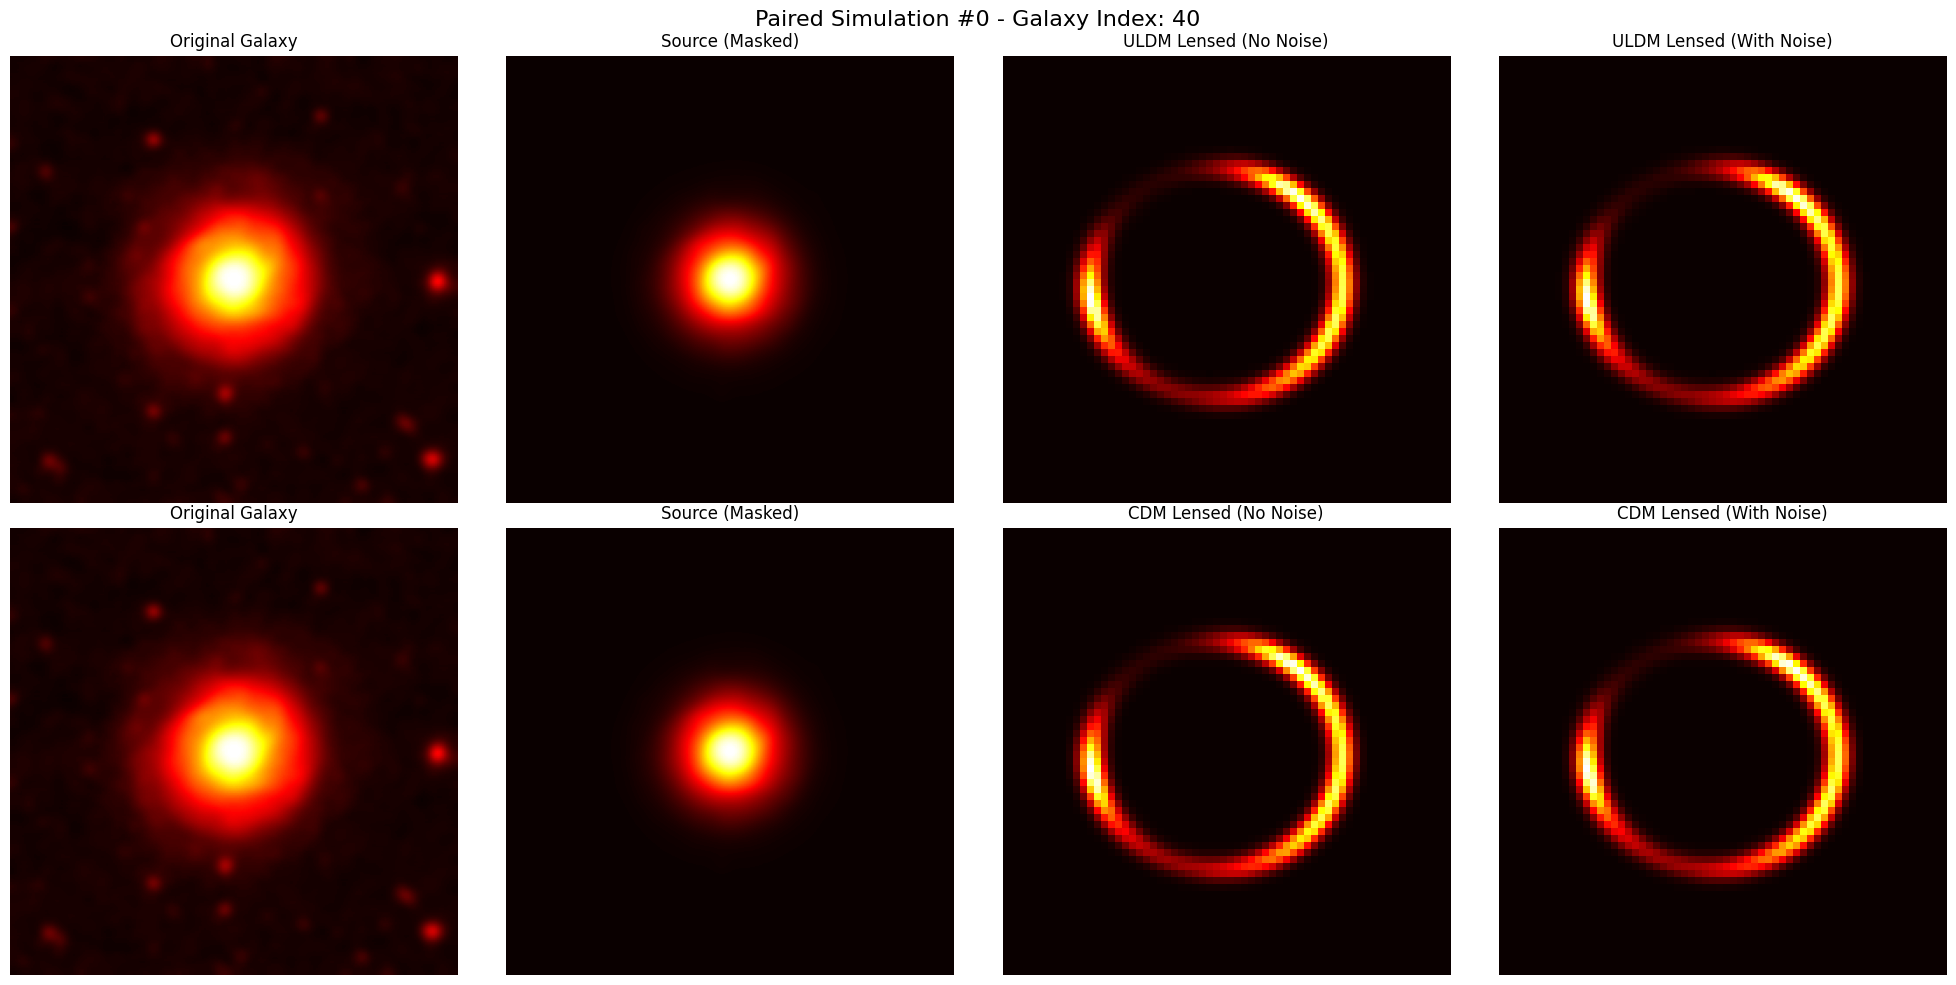

Visualizing ULDM with residuals...


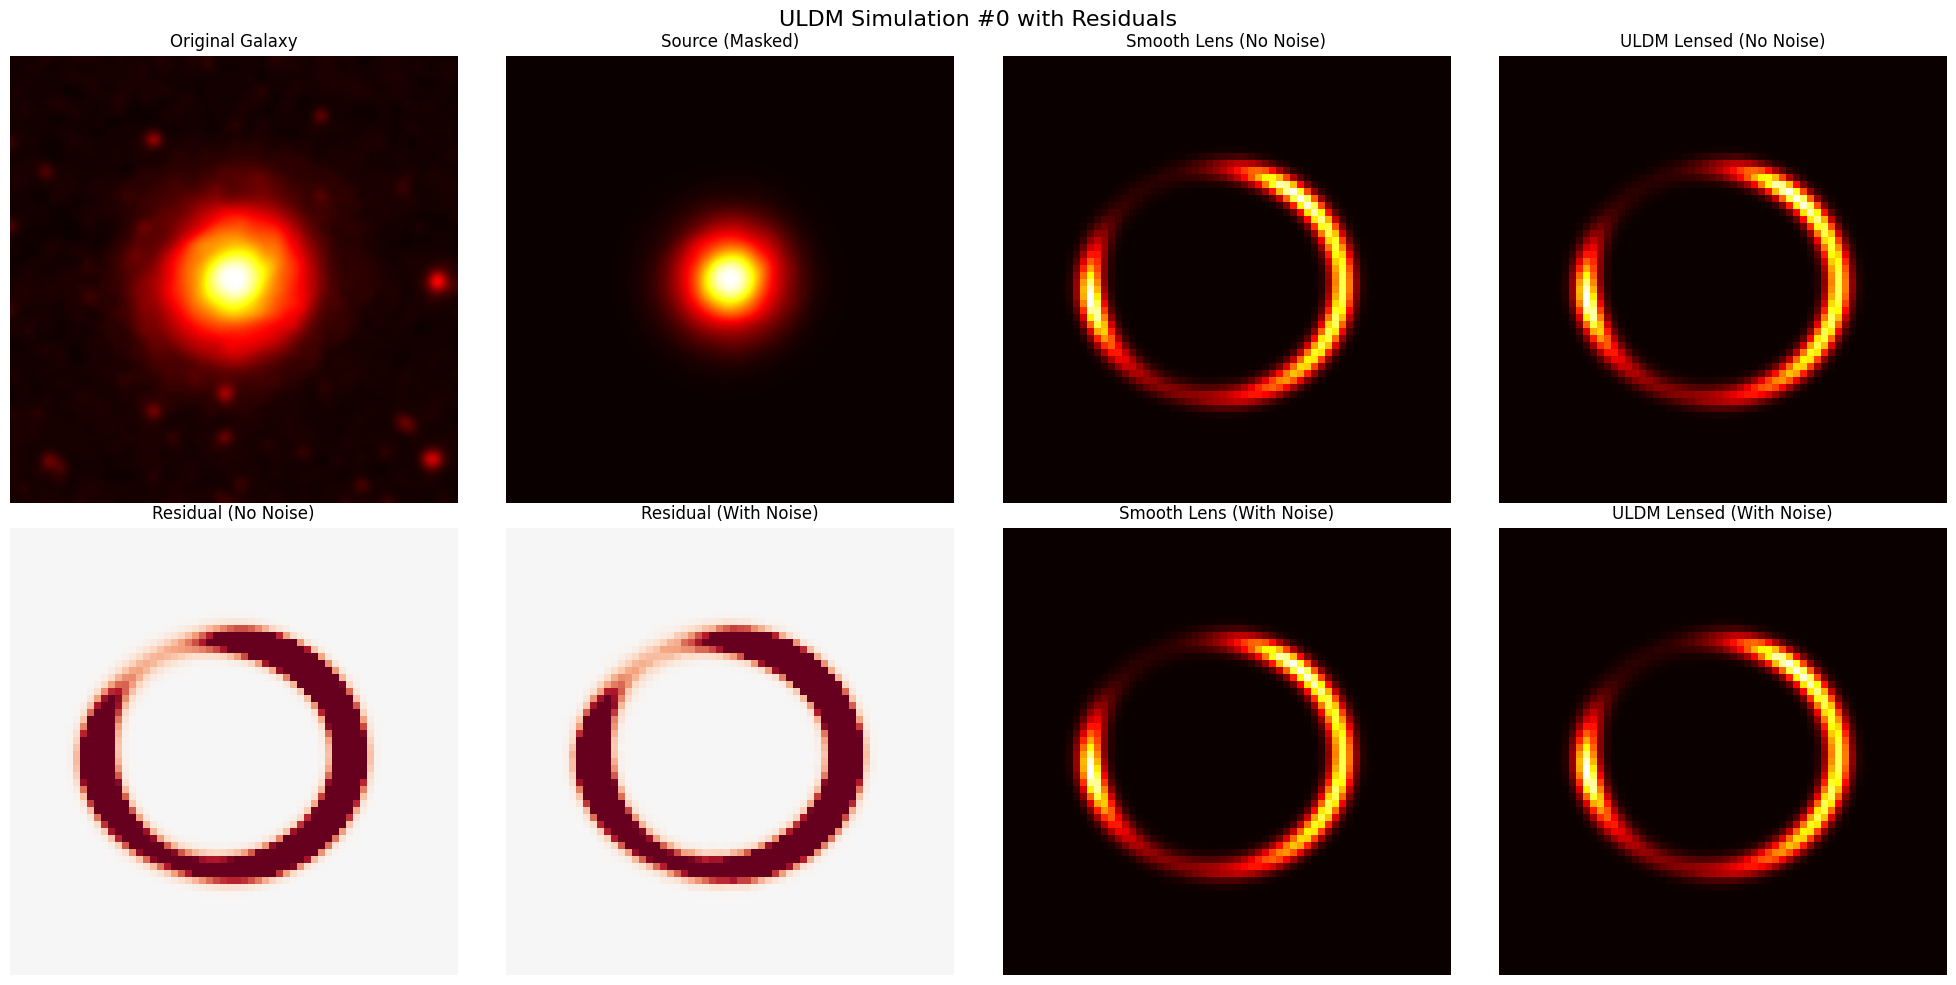

Visualizing CDM with residuals...


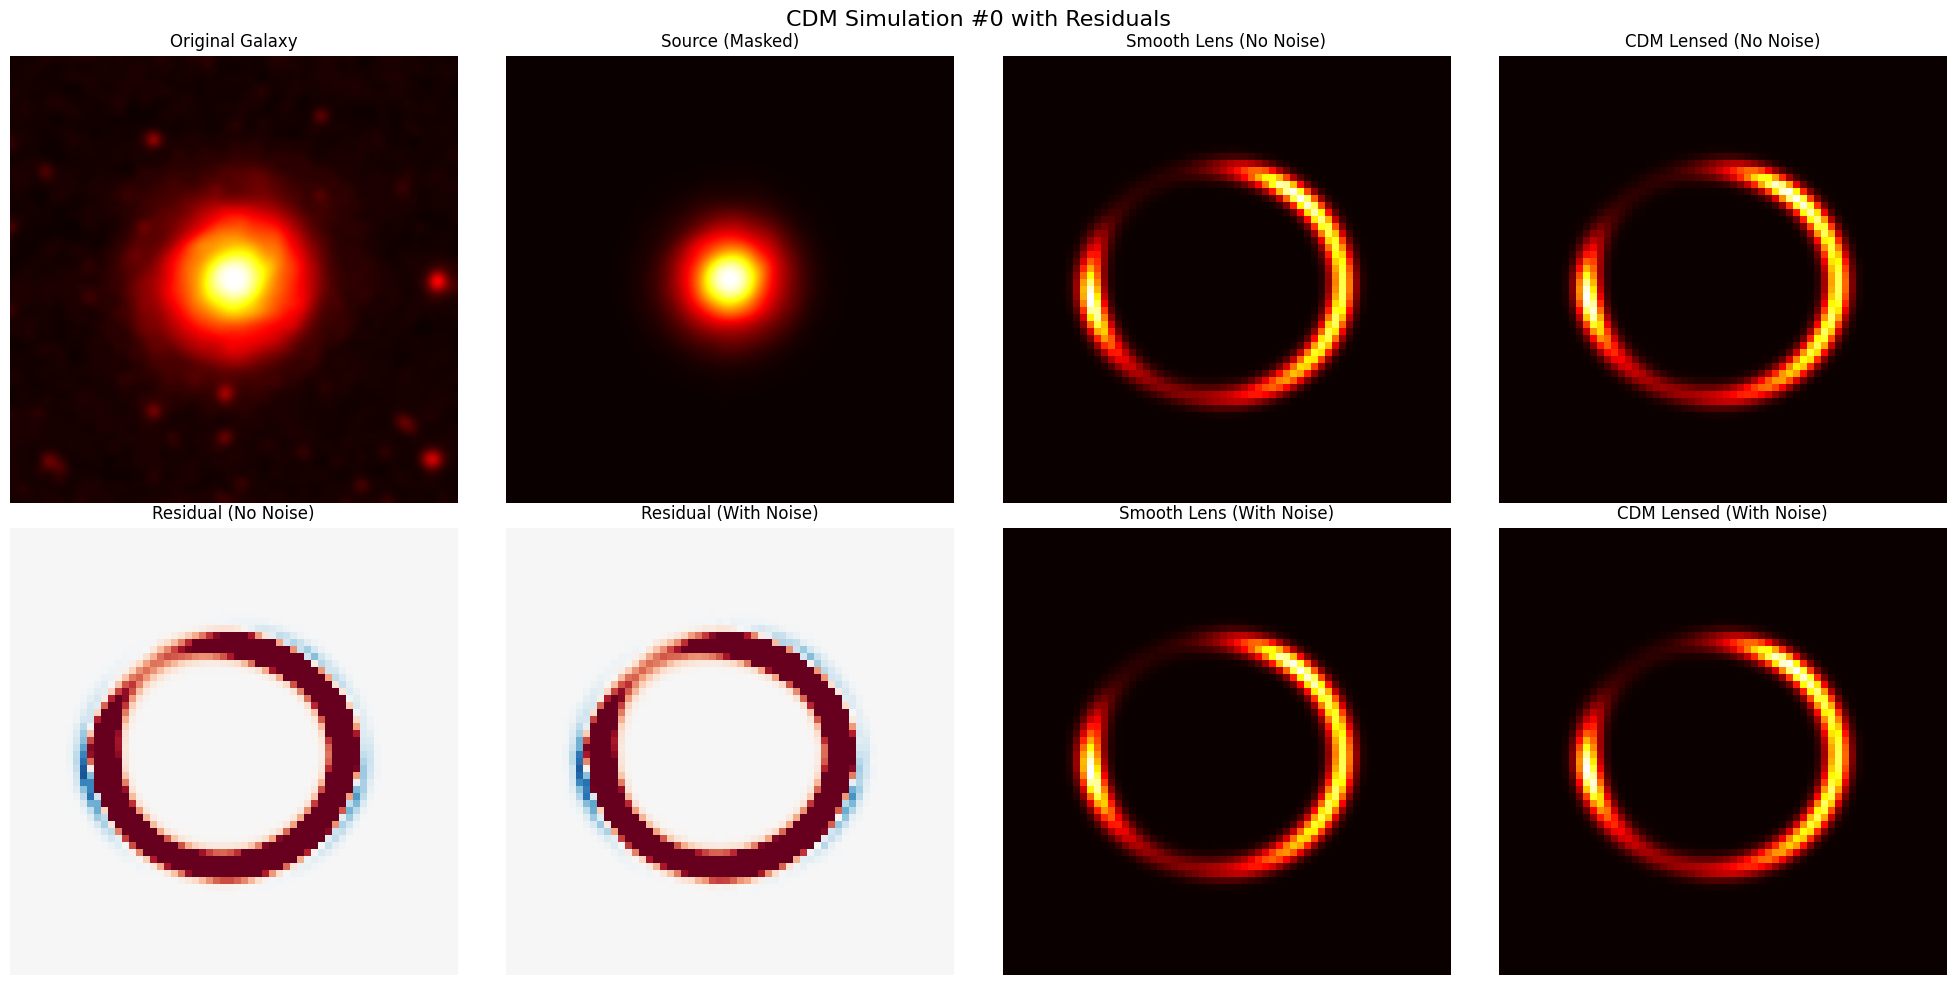

=== INDEPENDENT DATASET EXAMPLE ===
=== LOAD RESULTS EXAMPLE ===
=== CUSTOM SIMULATION EXAMPLE ===


"\nKEY PARAMETERS:\n\nnum_simulations: Number of simulations to generate\naxion_mass: Axion mass parameter for ULDM (typically -21 to -23)\noutput_dir: Directory to save simulation files\nsave_files: Whether to save files to disk\npaired: Whether to use same source galaxy for both models\n\nSIMULATION PARAMETERS (randomized if not specified):\n- Ens: Einstein radius (lensing strength)\n- source_pos_xx, source_pos_yy: Source position\n- source_ang: Source rotation angle\n- galaxy_index: Which galaxy from dataset to use\n\nOUTPUT STRUCTURE:\nEach simulation returns a dictionary with:\n- 'source_image': Masked source galaxy\n- 'original_galaxy': Original galaxy before masking\n- 'smooth_no_noise': Smooth lens without noise\n- 'smooth_with_noise': Smooth lens with noise\n- 'lensed_no_noise': Lensed image without noise\n- 'lensed_with_noise': Lensed image with noise\n- 'residual_no_noise': Difference (substructure signal)\n- 'residual_with_noise': Difference with noise\n- 'parameters': Simu

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import os
from tqdm import tqdm

def setup_galaxy_data():
    with h5py.File('Galaxy10_DECals.h5', 'r') as F:
        images = np.array(F['images'])
        typ = np.array(F['ans'])
        z = np.array(F['redshift'])
    unbarred_spiral = np.where(typ == 6)
    images_ref = images[unbarred_spiral]
    z_ref = z[unbarred_spiral]
    indx_img_zp1 = np.where(z_ref < 0.02)
    img_zp1 = images_ref[indx_img_zp1]
    print(f"Loaded {len(img_zp1)} galaxies for simulation")
    return img_zp1

def example_single_simulation():
    img_zp1 = setup_galaxy_data()
    print("Generating ULDM simulation...")
    uldm_result = generate_single_simulation_with_residuals(
        img_zp1, 
        model_type='uldm', 
        axion_mass=-21.5
    )
    print("Generating CDM simulation...")
    cdm_result = generate_single_simulation_with_residuals(
        img_zp1, 
        model_type='cdm'
    )
    save_simulation_results(uldm_result, './single_simulations', 0, 'uldm')
    save_simulation_results(cdm_result, './single_simulations', 0, 'cdm')
    print("Visualizing ULDM simulation...")
    results = {'uldm': [uldm_result]}
    visualize_simulation_with_residuals(results, 'uldm', 0)
    print("Visualizing CDM simulation...")
    results = {'cdm': [cdm_result]}
    visualize_simulation_with_residuals(results, 'cdm', 0)
    return uldm_result, cdm_result

def example_paired_dataset():
    img_zp1 = setup_galaxy_data()
    num_simulations = 500
    print(f"Generating {num_simulations} paired simulations...")
    results = generate_paired_dataset_with_residuals(
        num_simulations=num_simulations,
        img_zp1=img_zp1,
        output_dir='./paired_simulations',
        axion_mass=-21.5,
        save_files=True
    )
    print("Visualizing paired simulation #0...")
    visualize_paired_simulation(results, 0)
    print("Visualizing ULDM with residuals...")
    visualize_simulation_with_residuals(results, 'uldm', 0)
    print("Visualizing CDM with residuals...")
    visualize_simulation_with_residuals(results, 'cdm', 0)
    return results

def example_independent_dataset():
    img_zp1 = setup_galaxy_data()
    num_simulations = 20
    print(f"Generating {num_simulations} independent simulations for each model...")
    results = generate_dataset_with_residuals(
        num_simulations=num_simulations,
        img_zp1=img_zp1,
        output_dir='./independent_simulations',
        axion_mass=-21.5,
        save_files=True,
        paired=False
    )
    print(f"Generated {len(results['uldm'])} ULDM and {len(results['cdm'])} CDM simulations")
    if len(results['uldm']) > 0:
        visualize_simulation_with_residuals(results, 'uldm', 0)
    if len(results['cdm']) > 0:
        visualize_simulation_with_residuals(results, 'cdm', 0)
    return results

def example_load_results():
    simulation_id = 0
    output_dir = './paired_simulations'
    uldm_result = load_simulation_results(output_dir, simulation_id, 'uldm')
    print("Loaded ULDM simulation parameters:", uldm_result['parameters'])
    cdm_result = load_simulation_results(output_dir, simulation_id, 'cdm')
    print("Loaded CDM simulation parameters:", cdm_result['parameters'])
    results = {'uldm': [uldm_result], 'cdm': [cdm_result]}
    visualize_simulation_with_residuals(results, 'uldm', 0)
    return uldm_result, cdm_result

def example_custom_simulation():
    img_zp1 = setup_galaxy_data()
    custom_params = {
        'Ens': 1.8,
        'source_pos_xx': 0.2,
        'source_pos_yy': -0.1,
        'source_ang': np.pi/4
    }
    uldm_result = generate_single_simulation_with_residuals(
        img_zp1,
        model_type='uldm',
        axion_mass=-22.0,
        galaxy_index=5,
        fixed_params=custom_params
    )
    cdm_result = generate_single_simulation_with_residuals(
        img_zp1,
        model_type='cdm',
        galaxy_index=5,
        fixed_params=custom_params
    )
    save_simulation_results(uldm_result, './custom_simulations', 0, 'uldm')
    save_simulation_results(cdm_result, './custom_simulations', 0, 'cdm')
    results = {'uldm': [uldm_result], 'cdm': [cdm_result]}
    visualize_simulation_with_residuals(results, 'uldm', 0)
    visualize_simulation_with_residuals(results, 'cdm', 0)
    return uldm_result, cdm_result

if __name__ == "__main__":
    print("=== SINGLE SIMULATION EXAMPLE ===")
    # uldm_result, cdm_result = example_single_simulation()
    print("=== PAIRED DATASET EXAMPLE ===")
    results = example_paired_dataset()
    print("=== INDEPENDENT DATASET EXAMPLE ===")
    # results = example_independent_dataset()
    print("=== LOAD RESULTS EXAMPLE ===")
    # uldm_result, cdm_result = example_load_results()
    print("=== CUSTOM SIMULATION EXAMPLE ===")
    # uldm_result, cdm_result = example_custom_simulation()
